## **Model and Evaluation**

## Objectives

* Fetch dataset from Kaggle and download in inputs folder
* Inspect dataset and correct if need be
* Save inspected dataset in outputs folder

## Inputs

* Kaggle JSON file - Authentication Token 

## Outputs

* Generate Dataset: outputs/datasets/collection/Sales-Records

## Additional Comments

* Dataset was found on a public data base so there were no security concerns
* Kaggle JSON file was deleted since it contained Key

---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/House-Sales/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/House-Sales'

---

In [4]:
import numpy as np
import pandas as pd
df_raw_path = "outputs/datasets/collection/Sales-Records"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


In [5]:
df_filled = df.fillna(0)
df.fillna(0, inplace=True)

---

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
                                                                'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
                                                                'GarageYrBlt', 'GrLivArea', 'LotArea', 
                                                                'LotFrontage', 'MasVnrArea', 'OpenPorchSF',
                                                                'OverallCond', 'OverallQual', 'TotalBsmtSF',
                                                                'YearBuilt', 'YearRemodAdd'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['1stFlrSF', '2ndFlrSF',
                                           'BedroomAbvGr', 'BsmtFinSF1',
                                           'BsmtUnfSF', 'GarageArea',
                                           'GarageYrBlt', 'GrLivArea',
                                           'LotArea', 'LotFrontage',
                                           'MasVnrArea', 'OpenPorchSF',
                                           'OverallCond', 'OverallQual',
                                           'TotalBsmtSF', 'YearBuilt',
                                           'YearRemodAdd'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

In [7]:
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


---

In [18]:
variables_engineering= ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
                        'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
                        'GarageYrBlt', 'GrLivArea', 'LotArea', 
                        'LotFrontage', 'MasVnrArea', 'OpenPorchSF',
                        'OverallCond', 'OverallQual', 'TotalBsmtSF',
                       'YearBuilt', 'YearRemodAdd']

variables_engineering

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

In [22]:
print(X_train[variables_engineering].dtypes)

1stFlrSF          int64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtFinSF1        int64
BsmtUnfSF         int64
GarageArea        int64
GarageYrBlt     float64
GrLivArea         int64
LotArea           int64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF       int64
OverallCond       int64
OverallQual       int64
TotalBsmtSF       int64
YearBuilt         int64
YearRemodAdd      int64
dtype: object


In [23]:
X_train[variables_engineering] = X_train[variables_engineering].astype('object')

In [24]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 21) (1168,) (292, 21) (292,)


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:141: UserWarning: NaN values were introduced in the returned dataframe by the encoder.This means that some of the categories in the input dataframe were not present in the training set used when the fit method was called. Thus, mappings for those categories do not exist. Try using the RareLabelCategoricalEncoder to remove infrequ

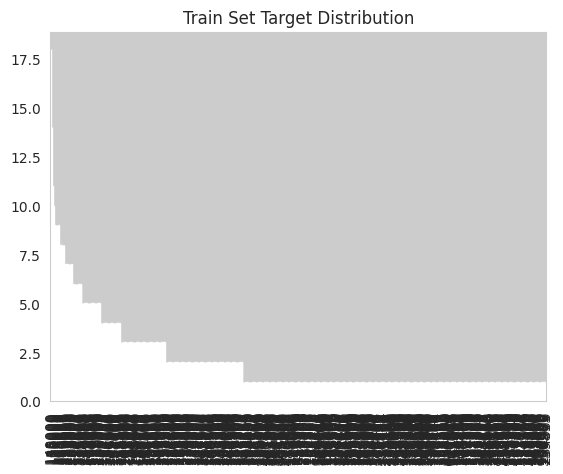

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [27]:
string_columns = X_train.select_dtypes(include='object').columns
print("Columns with string values:", string_columns)

Columns with string values: Index(['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dtype='object')


In [28]:
for column in string_columns:
    unique_values = X_train[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in BsmtExposure: ['Av' 'No' 'Gd' 'None' 'Mn']
Unique values in BsmtFinType1: [0 'Unf' 'ALQ' 'GLQ' 'Rec' 'None' 'LwQ' 'BLQ']
Unique values in GarageFinish: ['Unf' 0 'RFn' 'Fin' 'None']
Unique values in KitchenQual: ['Gd' 'TA' 'Ex' 'Fa']


In [33]:
categorical_columns= ['BsmtExposure', 'BsmtFinType1', 'GarageFinish',
                        'KitchenQual']

categorical_columns

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

In [34]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

In [35]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for col in categorical_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']

In [30]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ValueError: could not convert string to float: 'Av'